In [20]:
import mlflow
import xarray as xr
import matplotlib.pyplot as plt
from data.utils import load_training_datasets
import os

# %env MLFLOW_TRACKING_URI /scratch/ag7531/mlruns

In [21]:
import xarray as xr
import numpy as np
import math

In [22]:
data_test=True

In [23]:
if data_test==True:
  raw_data = xr.open_zarr('/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/offline_test/cm2p6/forcing.zarr')
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')
else:
  raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr')
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')

In [24]:
raw_datasets

[<xarray.Dataset>
 Dimensions:   (time: 32, yu_ocean: 645, xu_ocean: 900)
 Coordinates:
   * time      (time) object 0181-01-01 12:00:00 ... 0181-02-01 12:00:00
   * xu_ocean  (xu_ocean) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
   * yu_ocean  (yu_ocean) float64 -81.02 -80.86 -80.69 ... 84.53 84.7 84.87
 Data variables:
     S_x       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     S_y       (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     usurf     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
     vsurf     (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 645, 900), meta=np.ndarray>
 Attributes:
     filename:   01810101.ocean_minibling_surf_field.nc
     grid_tile:  1
     grid_type:  mosaic
     history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
     title:      CM2.6_miniBling]

In [25]:
low_rez = raw_datasets[0]
u = low_rez['usurf']
v = low_rez['vsurf']
# u = prog['u'].fillna(0)

In [26]:
low_rez.nbytes / 1e9

0.297228616

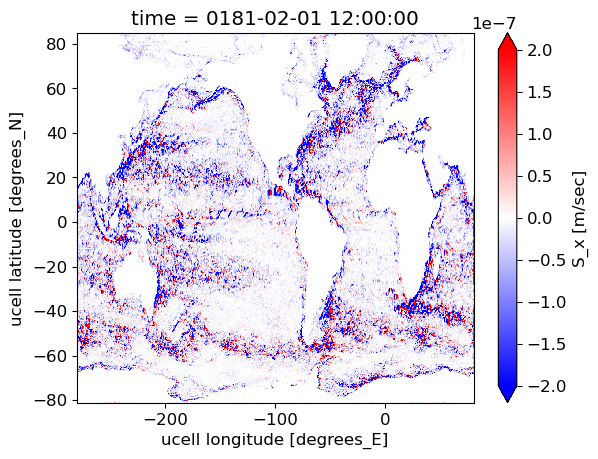

In [27]:
%matplotlib inline
low_rez['S_x'].isel(time=-1).plot(cmap='bwr',vmin=-2*1e-7, vmax = 2*1e-7)
plt.show()

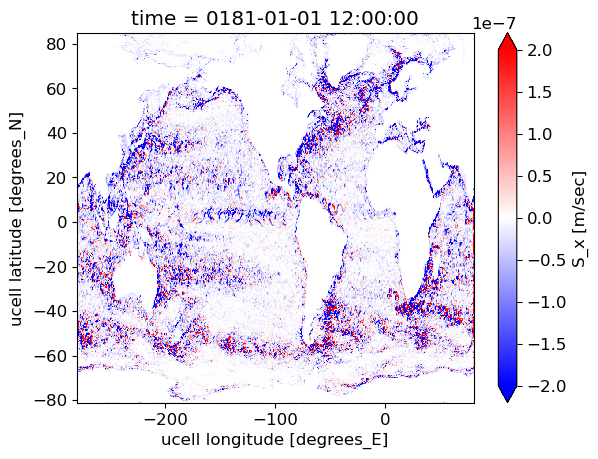

In [28]:
%matplotlib inline
low_rez['S_x'].isel(time=0).plot(cmap='bwr',vmin=-2*1e-7, vmax = 2*1e-7)
plt.show()

In [29]:
import torch
import importlib
#load the neural network
def load_model_cls(model_module_name: str, model_cls_name: str):
    try:
        module = importlib.import_module(model_module_name)
        model_cls = getattr(module, model_cls_name)
    except ModuleNotFoundError as e:
        raise type(e)('Could not retrieve the module in which the trained model \
                      is defined: ' + str(e))
    except AttributeError as e:
        raise type(e)('Could not retrieve the model\'s class. ' + str(e))
    return model_cls
def load_paper_net(device: str = 'gpu'):
    """
        Load the neural network from the paper
    """
    print('In load_paper_net()')
    model_module_name = 'models.models1'
    model_cls_name = 'FullyCNN'
    model_cls = load_model_cls(model_module_name, model_cls_name)
    print('After load_model_cls()')
    net = model_cls(2, 4)
    print('After net')
    if device == 'cpu':
        transformation = torch.load('/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/final_transformation.pth')
        print('After torch.load()')
    else:
        transformation = pickle_artifact(MODEL_RUN_ID, 'models/transformation')
    net.final_transformation = transformation
    print('After transformation')

    # Load parameters of pre-trained model
    print('Loading the neural net parameters')
    # logging.info('Loading the neural net parameters')
    # client = mlflow.tracking.MlflowClient()
    print('After mlflow.tracking.MlflowClient()')
#    model_file = client.download_artifacts(MODEL_RUN_ID,
#                                           'nn_weights_cpu.pth')
    model_file = '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/trained_model.pth'
    print('After download_artifacts()')
    if device == 'cpu':
        print('Device: CPU')
        model_file = '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/nn_weights_cpu.pth'
        net.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    else:
        net.load_state_dict(torch.load(model_file))
    # print(torch.load(model_file, map_location=torch.device('cpu')).keys())
    # print(net.state_dict().keys())
    print(net)
    return net
net = load_paper_net('cpu')

In load_paper_net()
After load_model_cls()
After net
After torch.load()
After transformation
Loading the neural net parameters
After mlflow.tracking.MlflowClient()
After download_artifacts()
Device: CPU
FullyCNN(
  (0): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1))
  (final_transformation): SoftPlusTransform(Parameter containing:
  tensor(-0.1793, requires_grad=True))
)


In [30]:
device = torch.device('cpu')
from train.losses import HeteroskedasticGaussianLossV2

In [31]:
criterion = HeteroskedasticGaussianLossV2(n_target_channels=2)

In [32]:
from testing.utils import (create_large_test_dataset, create_test_dataset)
from torch.utils.data import DataLoader

In [33]:
if data_test==True:
  from data.datasets import (RawDataFromXrDataset, DatasetTransformer,
                             Subset_, DatasetWithTransform, ComposeTransforms,
                             MultipleTimeIndices, DatasetPartitioner)
  low_rez = low_rez.fillna(0)
  dataset = RawDataFromXrDataset(low_rez * 10.)
  dataset.index = 'time'
  dataset.add_input('usurf')
  dataset.add_input('vsurf')
  dataset.add_output('S_x')
  dataset.add_output('S_y')
  features_transform_ = ComposeTransforms()
  targets_transform_ = ComposeTransforms()
  transform = DatasetTransformer(features_transform_, targets_transform_)
  transform.fit(dataset)
  dataset = DatasetWithTransform(dataset, transform)
  test = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device)
  test = test.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test

In [34]:
if data_test==True:
  dataset

In [35]:
if data_test==True:
  from dask.diagnostics import ProgressBar
  with ProgressBar():
      test = test.compute()
else:
   test = xr.open_dataset('/scratch/gpfs/cz3321/CM2P6/test_four_regions.nc')
test

[########################################] | 100% Completed | 52.59 s


<xarray.Dataset>
Dimensions:   (time: 32, yu_ocean: 645, xu_ocean: 900)
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0181-02-01 12:00:00
  * yu_ocean  (yu_ocean) float64 -81.02 -80.86 -80.69 ... 84.53 84.7 84.87
  * xu_ocean  (xu_ocean) float64 -279.7 -279.3 -278.9 ... 79.05 79.45 79.85
Data variables:
    S_x       (time, yu_ocean, xu_ocean) float32 -0.003023 ... -0.003023
    S_y       (time, yu_ocean, xu_ocean) float32 0.01055 0.01055 ... 0.01055
    S_xscale  (time, yu_ocean, xu_ocean) float32 128.5 128.5 ... 128.5 128.5
    S_yscale  (time, yu_ocean, xu_ocean) float32 141.9 141.9 ... 141.9 141.9

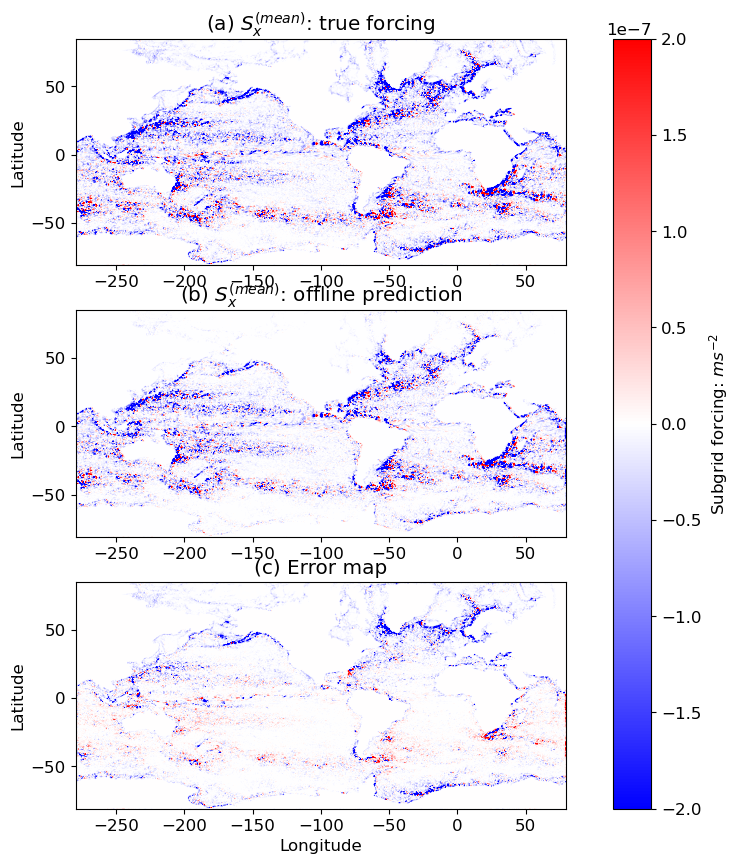

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
plt.rcParams.update({'font.size': 12})
ax = ax.reshape(-1)
S_test = test.isel(time=-1)['S_x']*(1e-7)
S_true = low_rez.isel(time=-1)['S_x']
error = S_true-S_test
xq = test['xu_ocean']
yq = test['yu_ocean']

p = ax[0].imshow(S_true, origin='lower',
    extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
    cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
# ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('(a) $S_{x}^{(mean)}$: true forcing')

p = ax[1].imshow(S_test, origin='lower',
    extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
    cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
# ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('(b) $S_{x}^{(mean)}$: offline prediction')

p = ax[2].imshow(error, origin='lower',
    extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
    cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')
ax[2].set_title('(c) Error map')

fig.colorbar(p, ax=ax, label='Subgrid forcing: $ms^{-2}$')
    # plt.savefig('../Paper_figures/figureB_1_1.png', dpi=300, bbox_inches="tight")

# test.isel(time=-10)['S_x'].plot(vmin=-1, vmax=1, cmap='bwr')

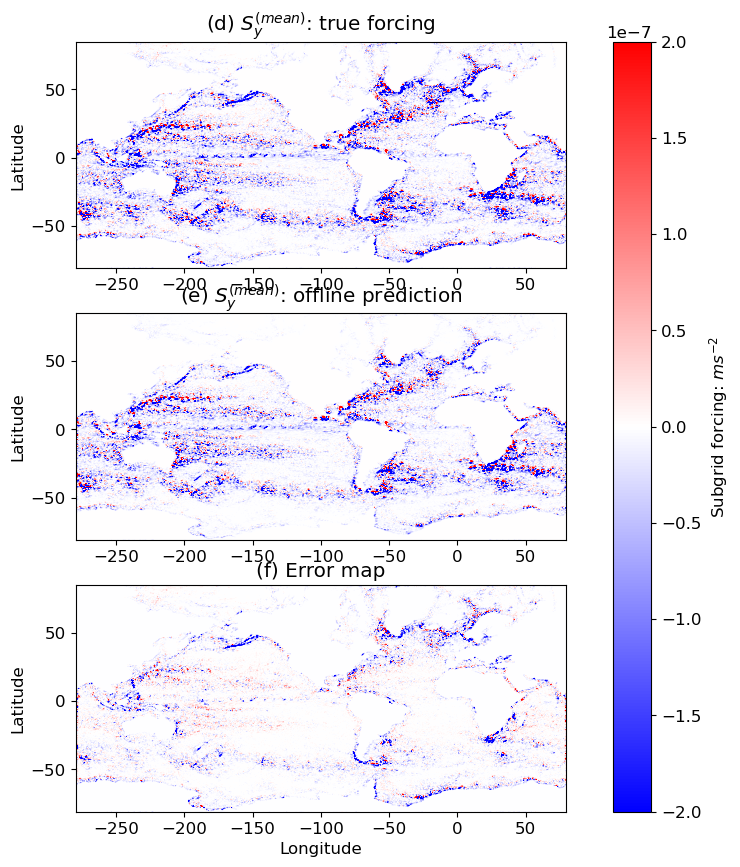

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(12,10))
plt.rcParams.update({'font.size': 12})
ax = ax.reshape(-1)
S_test = test.isel(time=-1)['S_y']*(1e-7)
S_true = low_rez.isel(time=-1)['S_y']
error = S_true-S_test
xq = test['xu_ocean']
yq = test['yu_ocean']

p = ax[0].imshow(S_true, origin='lower',
    extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
    cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
# ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('(d) $S_{y}^{(mean)}$: true forcing')

p = ax[1].imshow(S_test, origin='lower',
    extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
    cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
# ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('(e) $S_{y}^{(mean)}$: offline prediction')

p = ax[2].imshow(error, origin='lower',
    extent=[xq.min(),xq.max(),yq.min(),yq.max()], 
    cmap='bwr', vmin=-2*1e-7, vmax = 2*1e-7)
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Latitude')
ax[2].set_title('(f) Error map')

fig.colorbar(p, ax=ax, label='Subgrid forcing: $ms^{-2}$')
    # plt.savefig('../Paper_figures/figureB_1_2.png', dpi=300, bbox_inches="tight")

# (low_rez.isel(time=-10)['S_x']*1e7).plot(vmin=-1, vmax=1, cmap='bwr')

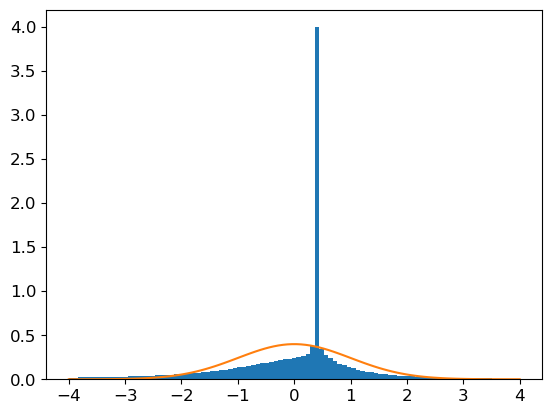

In [38]:
from scipy.stats import norm
plt.figure()
((low_rez['S_x']*1e7 - test['S_x'])
 * (test['S_xscale'])).plot.hist(bins=np.linspace(-4, 4, 100), density=True)
plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)))

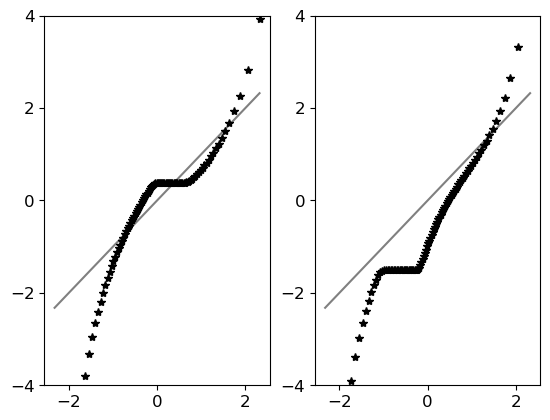

In [39]:
plt.figure()
for i, var in enumerate(['S_x', 'S_y']):
    residuals_t = ((low_rez[var]*1e7 - test[var]) * (test[f'{var}scale']))
    quantiles = np.linspace(0., 1., 100)
    norm_quantiles = norm.ppf(quantiles)
    obs_quantiles = np.nanquantile(residuals_t.values[::20, ::, ::], quantiles)
    plt.subplot(1, 2, i + 1)
    plt.plot(norm_quantiles, norm_quantiles, 'gray')
    plt.plot(norm_quantiles, obs_quantiles, 'k*')
    plt.ylim(-4, 4)
    plt.yticks(np.arange(-4, 5, 2))

In [40]:
# x = low_rez['S_x'].values.flatten()
# x = np.nan_to_num(x, nan=0)
# y = test['S_x'].values.flatten()*1e-7

# plt.scatter(x, y, s=10, alpha=0.5)

# fitcoef = np.polyfit(x, y, 1)
# regression_line = fitcoef[0] * x + fitcoef[1]

# plt.plot(x, regression_line, color='red', label='Linear Regression')

# plt.plot(x, x, linestyle='dashed', color='black', label='y=x')

# plt.xlabel('Sx_true')
# plt.ylabel('Sx_pred')
# plt.legend()

# correlation = np.corrcoef(x, y)[0, 1]
# print(correlation)

# plt.show()

In [41]:
mse = dict()
variance = dict()
r_squared = dict()
correlation = dict()
for var in ['S_x', 'S_y']:
    mse[var] = ((test[var] - low_rez[var]*1e7)**2).mean(dim='time')
    variance[var] = ((low_rez[var]*1e7)**2).mean(dim='time')
    r_squared[var] = 1 - mse[var] / variance[var]
    correlation[var] = xr.corr(test[var], low_rez[var]*1e7, dim='time')

/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/cz3321/.conda/envs/smartsim_gpu2/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


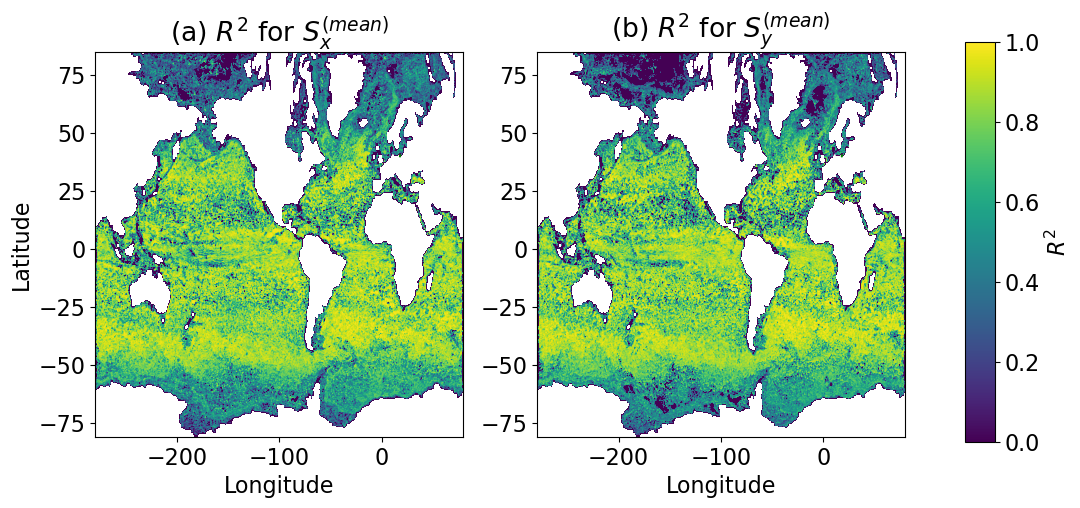

In [42]:
from matplotlib.patches import Arrow, Circle
fig = plt.figure(figsize=(12,5))
plt.rcParams.update({'font.size': 16})
extent = (low_rez['xu_ocean'].min(), low_rez['xu_ocean'].max(), low_rez['yu_ocean'].min(), low_rez['yu_ocean'].max())
for i, var in enumerate(['S_x', 'S_y']):
    plt.subplot(1, 2, i + 1)
    im = plt.imshow(r_squared[var].values, vmin=0., vmax=1,
                   origin='lower', extent=extent, aspect="auto")
    
    if i == 0:
        plt.ylabel('Latitude')
        patches = [Circle((11, 40), radius=0.4, color='white'),
                     Circle((18, 40), radius=0.4, color='green'),]
        for patch in patches:
              im.axes.add_patch(patch)
        plt.title('(a) $R^2$ for $S_{x}^{(mean)}$')
    elif i == 1:
        patches = [Circle((11, 40), radius=0.4, color='white'),
                     Circle((18, 40), radius=0.4, color='green'),]
        for patch in patches:
              im.axes.add_patch(patch)
        plt.title('(b) $R^2$ for $S_{y}^{(mean)}$')
    plt.xlabel('Longitude')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax, label=r'$R^2$')

In [43]:
Sx=r_squared['S_x']

In [44]:
low_rez['xu_ocean']
low_rez['yu_ocean']

<xarray.DataArray 'yu_ocean' (yu_ocean: 645)>
array([-81.024153, -80.855196, -80.686238, ...,  84.530019,  84.698977,
        84.867934])
Coordinates:
  * yu_ocean  (yu_ocean) float64 -81.02 -80.86 -80.69 ... 84.53 84.7 84.87
Attributes:
    cartesian_axis:  Y
    long_name:       ucell latitude
    units:           degrees_N

44   40


NameError: name 'LAYER' is not defined

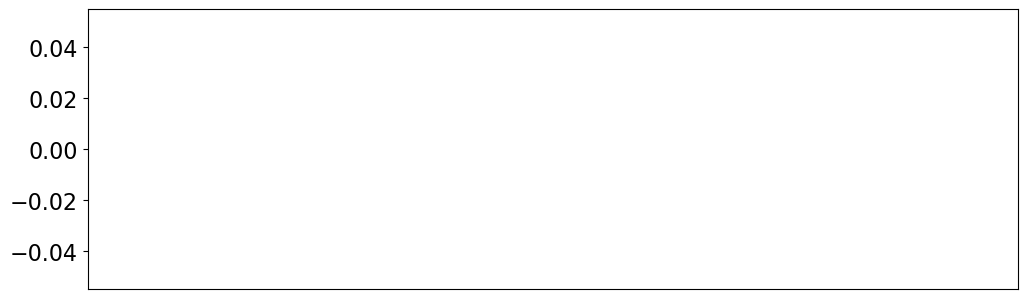

In [45]:
x = 44
y = 40
s = (60, 120) 
print(x, ' ', y)
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
for i, var in enumerate(['S_x', 'S_y']):
    ax = plt.subplot(2, 1, i + 1)
    plt.plot(low_rez['time'][s[0]:s[1]]/365, low_rez[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))*1e7)
    plt.plot(low_rez['time'][s[0]:s[1]]/365, test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
    ub = (test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
          + 1.96 / test[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
    lb = (test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
          - 1.96 / test[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
    plt.plot(test['time'][s[0]:s[1]]/365, ub, '--g')
    plt.plot(test['time'][s[0]:s[1]]/365, lb, '--g')
    if i == 0:
        ax.set_xticks([])
        ax.set_title('(e) '+LAYER+' at $(11^{\circ},40^{\circ})$, white dot')
    if i == 1:
        plt.xlabel('time (years)')
    plt.ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')
if layer==0:
    plt.savefig('../Paper_figures/figureB_3.png', dpi=300, bbox_inches="tight")

In [ ]:
x = 72
y = 40
s = (60, 120) 
print(x, ' ', y)
fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
for i, var in enumerate(['S_x', 'S_y']):
    ax = plt.subplot(2, 1, i + 1)
    plt.plot(low_rez['time'][s[0]:s[1]]/365, low_rez[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))*1e7)
    plt.plot(low_rez['time'][s[0]:s[1]]/365, test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
    ub = (test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
          + 1.96 / test[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
    lb = (test[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
          - 1.96 / test[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
    plt.plot(test['time'][s[0]:s[1]]/365, ub, '--g')
    plt.plot(test['time'][s[0]:s[1]]/365, lb, '--g')
    if i == 0:
        ax.set_xticks([])
        ax.set_title('(f) '+LAYER+' at $(18^{\circ},40^{\circ})$, green dot')
    if i == 1:
        plt.xlabel('time (years)')
    plt.ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')
if layer==0:
    plt.savefig('../Paper_figures/figureB_4.png', dpi=300, bbox_inches="tight")

In [ ]:
plt.figure()
#((low_rez['S_y']*1e7 - test['S_y']).median(dim='time') ).plot()
#residuals_t.median(dim='time').plot(vmin=0, vmax=1)
(abs(((low_rez['S_x']*1e7 - test['S_x'])).mean(dim='time') / (low_rez['S_x']*1e7).std(dim='time'))).plot(vmin=0, vmax=0.5)

In [ ]:
plt.figure()
(np.log((low_rez['S_y']*1e7).std(dim='time'))).plot(vmin=-5, vmax=5)